In [1]:
import dash
from dash import Dash, dcc, html
import dash_bootstrap_components as dbc
import plotly.graph_objects as go
import numpy as np
import datetime

def holidays():
    year = datetime.datetime.now().year

    d1 = datetime.date(year, 8, 1)
    d2 = datetime.date(year + 1, 7, 15)
    delta = d2 - d1

    dates_in_year = [d1 + datetime.timedelta(i) for i in range(delta.days + 1)]
    # Weekday: 0..6 (Mon..Sun)
    weekdays_in_year = [d.weekday() for d in dates_in_year]
    # ISO year-week label (keeps week numbering consistent across year boundary)
    week_labels_per_date = [d.strftime("%G-ww%V")[2:] for d in dates_in_year]  # e.g., "25-ww31"

    # Unique weeks in order of appearance (columns)
    week_labels = []
    for w in week_labels_per_date:
        if w not in week_labels:
            week_labels.append(w)

    n_weeks = len(week_labels)

    # Random activity (0/1) for demo; replace with your own vector
    z_1d = np.random.randint(0, 2, size=len(dates_in_year))

    # Build a 7 x n_weeks grid (rows=Mon..Sun, cols=week)
    z_grid = np.full((7, n_weeks), np.nan)
    for i, d in enumerate(dates_in_year):
        r = weekdays_in_year[i]                          # 0..6
        c = week_labels.index(week_labels_per_date[i])   # column index
        z_grid[r, c] = z_1d[i]

    # Numeric colorscale (0..1)
    colorscale = [[0.0, '#eeeeee'], [1.0, '#76cf63']]

    fig = go.Figure(
        data=[
            go.Heatmap(
                x=week_labels,
                y=list(range(7)),    # 0..6
                z=z_grid,
                hoverinfo="x+y+z",
                xgap=3,
                ygap=3,
                showscale=False,
                colorscale=colorscale
            )
        ]
    )

    fig.update_layout(
        title='activity chart',
        height=280,
        yaxis=dict(
            showline=False, showgrid=False, zeroline=False,
            tickmode="array",
            ticktext=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
            tickvals=[0, 1, 2, 3, 4, 5, 6],
        ),
        xaxis=dict(showline=False, showgrid=False, zeroline=False),
        font={'size': 10, 'color': '#9e9e9e'},
        plot_bgcolor='#ffffff',
        paper_bgcolor='#ffffff',
        margin=dict(t=40, l=10, r=10, b=10),
    )
    return fig

# ---- Dash app (vanilla Dash; works in Colab that provides app.run(mode='inline')) ----
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = html.Div([
    dcc.Graph(id="heatmap-test", figure=holidays(), config={"displayModeBar": False})
])

if __name__ == "__main__":
    # Colab environments that patch Dash support this:
    app.run(mode='inline', debug=False)

In [3]:
# --- imports ---
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta

# -------------------------------
# 1) Synthesize data (last ~2 mo)
# -------------------------------
np.random.seed(7)

today = pd.Timestamp.today().normalize()
start = today - pd.Timedelta(days=60)

# init dates ~ daily
init_dates = pd.date_range(start, today, freq="D")
lead_days = np.arange(0, 11)  # 0..10 days of lead time
models = ["gfs", "ifs"]

rows = []
for m in models:
    for init in init_dates:
        # model-dependent noise scale (ifs usually a bit "tighter" here just for variety)
        base_sigma = 0.9 if m == "ifs" else 1.1
        for L in lead_days:
            valid = init + pd.Timedelta(days=int(L))
            if valid > today:
                continue
            # obs and fc (simple synthetic process)
            obs = np.clip(np.random.normal(8, 2.5), 0, None)
            fc  = obs + np.random.normal(0, base_sigma * (1 + 0.15*L))  # spread grows with lead
            rows.append([valid, init, L, obs, fc, m])

df = pd.DataFrame(rows, columns=["date","initDate","lead_days","obsWind","fcWind","model"])

# ------------------------------------------
# 2) Score & classify (Low / Medium / High / Critical)
# ------------------------------------------
df["abs_error"] = (df["fcWind"] - df["obsWind"]).abs()

# thresholds in m/s (tune as you like)
bins = [-np.inf, 1.0, 2.0, 3.0, np.inf]
labels = ["Low", "Medium", "High", "Critical"]
df["class"] = pd.cut(df["abs_error"], bins=bins, labels=labels, right=False)

# ------------------------------------------
# 3) Weekly aggregation (x-axis = week)
# ------------------------------------------
# week label (ISO week): e.g., '2025-W38'
df["week"] = df["date"].dt.strftime("%G-W%V")

# Aggregate to (model, week, lead_days) → mean abs error, then re-classify
weekly = (
    df.groupby(["model","week","lead_days"], as_index=False)["abs_error"]
      .mean()
      .rename(columns={"abs_error":"mean_abs_error"})
)
weekly["class"] = pd.cut(weekly["mean_abs_error"], bins=bins, labels=labels, right=False)

# Keep only the last ~8–9 weeks present
week_order = sorted(weekly["week"].unique())[-9:]

# ------------------------------------------
# 4) Make 2D matrices (rows = lead_days, cols = week)
# ------------------------------------------
class_to_code = {"Low":0, "Medium":1, "High":2, "Critical":3}
code_to_class = {v:k for k,v in class_to_code.items()}

def matrix_for(model_name):
    sub = weekly[weekly["model"] == model_name].copy()
    # Ensure full grid exists (use NaN codes for missing cells)
    idx = pd.MultiIndex.from_product([lead_days, week_order], names=["lead_days","week"])
    sub = sub.set_index(["lead_days","week"]).reindex(idx).reset_index()
    z_codes = sub["class"].map(class_to_code)
    # reshape to (rows=lead_days, cols=week)
    Z = z_codes.values.reshape(len(lead_days), len(week_order))
    return Z

Z_gfs = matrix_for("gfs")
Z_ifs = matrix_for("ifs")

# Discrete colorscale for codes 0..3
# (positions are midpoints of bins so blocks are solid)
colorscale = [
    [0.00, "#4CAF50"],  # Low      (green)
    [0.24, "#4CAF50"],
    [0.25, "#F4C542"],  # Medium   (yellow)
    [0.49, "#F4C542"],
    [0.50, "#FF8C42"],  # High     (orange)
    [0.74, "#FF8C42"],
    [0.75, "#E74C3C"],  # Critical (red)
    [1.00, "#E74C3C"],
]

# ------------------------------
# 5) Figure with two heatmaps
# ------------------------------
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("GFS", "IFS"),
    shared_yaxes=True,
    horizontal_spacing=0.08
)

def add_heatmap(Z, title, col):
    fig.add_trace(
        go.Heatmap(
            z=Z,
            x=week_order,
            y=lead_days,
            colorscale=colorscale,
            zmin=0, zmax=3,
            showscale=False,     # hide numeric colorbar; we’ll add a custom legend
            xgap=2, ygap=2,
            hovertemplate=(
                "<b>%{x}</b><br>"           # week
                "Lead (days): %{y}<br>"
                "Class: %{customdata}<extra></extra>"
            ),
            customdata=np.vectorize(code_to_class.get)(Z)
        ),
        row=1, col=col
    )

add_heatmap(Z_gfs, "GFS", 1)
add_heatmap(Z_ifs, "IFS", 2)

# Custom categorical legend (dummy scatter markers)
legend_items = [("Low", "#4CAF50"), ("Medium", "#F4C542"), ("High", "#FF8C42"), ("Critical", "#E74C3C")]
for name, color in legend_items:
    fig.add_trace(
        go.Scatter(
            x=[None], y=[None],
            mode="markers",
            marker=dict(size=12, color=color),
            name=name
        ),
        row=1, col=2  # legend is global; col doesn't matter
    )

fig.update_xaxes(title_text="Week (last ~2 months)", tickangle=0, showgrid=False)
fig.update_yaxes(title_text="Lead time (days)", dtick=1, showgrid=False)

fig.update_layout(
    title="Weekly Forecast Class by Lead Time (GFS vs IFS)",
    margin=dict(t=60, r=10, b=40, l=60),
    legend=dict(orientation="h", yanchor="bottom", y=1.12, xanchor="center", x=0.5),
    plot_bgcolor="white",
    paper_bgcolor="white",
)

fig.show()

# ------------------------------
# 6) If you also want the raw DF
# ------------------------------
# df  -> row-level (date, initDate, lead_days, obsWind, fcWind, model)
# weekly -> weekly aggregation (model, week, lead_days, mean_abs_error, class)


In [8]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ---------------------------
# 1) Dataset sintético (mismo esquema)
# ---------------------------
np.random.seed(1)
today = pd.Timestamp.today().normalize()
start = today - pd.Timedelta(days=70)

dates = pd.date_range(start, today, freq="D")
models = ["gfs", "ifs"]
rows = []
for m in models:
    for d in dates:
        for L in range(0, 15):  # 0–14
            init = d - pd.Timedelta(days=L)
            obs = np.clip(np.random.normal(8, 2.5), 0, None)
            fc = obs + np.random.normal(0, (1.2 if m=="gfs" else 0.9) * (1 + 0.15*L))
            rows.append([d, init, L, obs, fc, m])

df = pd.DataFrame(rows, columns=["date","initDate","lead_days","obsWind","fcWind","model"])

# ---------------------------
# 2) Métrica y clasificación
# ---------------------------
df["abs_error"] = (df["fcWind"] - df["obsWind"]).abs()

# thresholds (ajústalos a tu criterio)
bins = [-np.inf, 1, 2, 3, np.inf]
labels = ["Low","Medium","High","Critical"]

# ---------------------------
# 3) Filtrar al mes más reciente y semanas 1–4 del mes
# ---------------------------
df["month"] = df["date"].dt.to_period("M")
last_month = df["month"].max()
df = df[df["month"] == last_month].copy()

# semana del mes (1..5); nos quedamos con 1..4
df["week_of_month"] = df["date"].apply(lambda d: (d.day-1)//7 + 1)
df = df[df["week_of_month"].between(1,4)]

# ---------------------------
# 4) Agregación diaria -> promedio por (model, week_of_month, lead_days)
# ---------------------------
daily = (
    df.groupby(["model","week_of_month","lead_days"], as_index=False)["abs_error"]
      .mean()
      .rename(columns={"abs_error":"mean_abs_error"})
)
daily["class"] = pd.cut(daily["mean_abs_error"], bins=bins, labels=labels, right=False)

# dominios
weeks = [1,2,3,4]
leads = list(range(0,15))

# ---------------------------
# 5) Construir matrices por clase (una traza por clase)
# ---------------------------
class_to_code = {"Low":0, "Medium":1, "High":2, "Critical":3}
code_colors = {
    "Low":     "#4CAF50",
    "Medium":  "#F4C542",
    "High":    "#FF8C42",
    "Critical":"#E74C3C"
}

def matrices_por_clase(model_name):
    """Devuelve un dict: clase -> matriz (4 x 15) con NaN fuera de la clase."""
    sub = daily[daily["model"]==model_name].copy()
    # grid completo
    idx = pd.MultiIndex.from_product([weeks, leads], names=["week_of_month","lead_days"])
    sub = sub.set_index(["week_of_month","lead_days"]).reindex(idx).reset_index()
    out = {}
    for cls in labels:
        mask = (sub["class"] == cls).astype(float)
        # donde no es la clase -> NaN
        mask[mask == 0.0] = np.nan
        out[cls] = mask.values.reshape(len(weeks), len(leads))
    return out

Z_gfs = matrices_por_clase("gfs")
Z_ifs = matrices_por_clase("ifs")

# ---------------------------
# 6) Figura: 2 filas (GFS, IFS) y leyenda compartida por clase
# ---------------------------
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("GFS", "IFS"),
    shared_xaxes=True,
    vertical_spacing=0.12
)

def add_panel(Z_dict, row, showlegend=False):
    for cls in labels:
        fig.add_trace(
            go.Heatmap(
                z=Z_dict[cls],
                x=leads,
                y=weeks,
                colorscale=[[0, code_colors[cls]], [1, code_colors[cls]]],  # color sólido
                zmin=0, zmax=1,
                showscale=False,
                xgap=2, ygap=2,
                hovertemplate=(
                    "Lead: %{x} días<br>"
                    "Semana del mes: %{y}<br>"
                    f"Clase: {cls}<extra></extra>"
                ),
                name=cls,
                legendgroup=cls,         # MISMO grupo por clase
                showlegend=showlegend,   # solo en la primera fila mostramos leyenda
            ),
            row=row, col=1
        )

# primera fila muestra leyenda
add_panel(Z_gfs, row=1, showlegend=True)
# segunda fila oculta leyenda, pero comparte legendgroup (togglegroup afectará ambos)
add_panel(Z_ifs, row=2, showlegend=False)

fig.update_xaxes(title="Lead time (days)", row=2, col=1, dtick=1)
fig.update_yaxes(title="Semana del mes", row=1, col=1, dtick=1)
fig.update_yaxes(title="Semana del mes", row=2, col=1, dtick=1)

fig.update_layout(
    title=f"Clasificación diaria por Lead (0–14) y Semana del Mes · {str(last_month)}",
    margin=dict(t=80, r=20, b=60, l=60),
    plot_bgcolor="white",
    paper_bgcolor="white",
    legend=dict(
        orientation="h",
        yanchor="bottom", y=1.08,
        xanchor="center", x=0.5
    ),
    legend_groupclick="togglegroup"   # <-- click en una clase oculta/mostrar ambas filas
)

fig.show()


In [12]:
# --- Imports ---
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# =========================================================
# 1) Build a synthetic dataset (same schema as your real DF)
#    Columns: date, initDate, lead_days, obsWind, fcWind, model
#    -> Replace this block with your real df if you have it.
# =========================================================
np.random.seed(42)
today = pd.Timestamp.today().normalize()
start = today - pd.Timedelta(days=70)

dates = pd.date_range(start, today, freq="D")
models = ["gfs", "ifs"]

rows = []
for m in models:
    for d in dates:
        for L in range(0, 15):  # lead_days 0..14
            init = d - pd.Timedelta(days=L)
            obs = np.clip(np.random.normal(8, 2.5), 0, None)
            fc  = obs + np.random.normal(0, (1.2 if m == "gfs" else 0.9) * (1 + 0.15*L))
            rows.append([d, init, L, obs, fc, m])

df = pd.DataFrame(rows, columns=["date","initDate","lead_days","obsWind","fcWind","model"])

# If you have your real df, keep the same column names and just do:
# df = your_dataframe.copy()

# =========================================================
# 2) Metric & classification (daily absolute error)
# =========================================================
df["abs_error"] = (df["fcWind"] - df["obsWind"]).abs()

# Thresholds for classes (tune as needed)
bins   = [-np.inf, 1.0, 2.0, 3.0, np.inf]
labels = ["Low","Medium","High","Critical"]

# =========================================================
# 3) Filter to most recent month and compute week-of-month (1..4)
# =========================================================
df["month"] = df["date"].dt.to_period("M")
last_month = df["month"].max()
df = df[df["month"] == last_month].copy()

# Week-of-month as 1..5; we’ll use only 1..4 (four rows)
df["week_of_month"] = df["date"].apply(lambda d: (d.day - 1)//7 + 1)
df = df[df["week_of_month"].between(1, 4)]

# =========================================================
# 4) Aggregate per day → average by (model, week_of_month, lead_days)
# =========================================================
daily = (
    df.groupby(["model","week_of_month","lead_days"], as_index=False)["abs_error"]
      .mean()
      .rename(columns={"abs_error":"mean_abs_error"})
)
daily["class"] = pd.cut(daily["mean_abs_error"], bins=bins, labels=labels, right=False)

# Axes domains
weeks = [1, 2, 3, 4]               # Y
leads = list(range(0, 15))         # X

# Colors for each class
code_colors = {
    "Low":      "#4CAF50",  # green
    "Medium":   "#F4C542",  # yellow
    "High":     "#FF8C42",  # orange
    "Critical": "#E74C3C",  # red
}

# =========================================================
# 5) Create one 4x15 matrix per class per model (NaN elsewhere)
#    -> lets us draw one Heatmap trace per class (solid color)
# =========================================================
def matrices_by_class(model_name):
    sub = daily[daily["model"] == model_name].copy()
    # Complete grid (weeks x leads)
    idx = pd.MultiIndex.from_product([weeks, leads], names=["week_of_month","lead_days"])
    sub = sub.set_index(["week_of_month","lead_days"]).reindex(idx).reset_index()
    out = {}
    for cls in labels:
        m = (sub["class"] == cls).astype(float)   # 1 where class, 0 otherwise
        m[m == 0.0] = np.nan                      # keep only class cells visible
        out[cls] = m.values.reshape(len(weeks), len(leads))
    return out

Z_gfs = matrices_by_class("gfs")
Z_ifs = matrices_by_class("ifs")

# =========================================================
# 6) Figure: two rows (GFS, IFS). Legend uses round markers.
#    Clicking a class toggles it in BOTH heatmaps.
# =========================================================
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("GFS", "IFS"),
    shared_xaxes=True,
    vertical_spacing=0.12
)

def add_panel(Z_dict, row):
    for cls in labels:
        fig.add_trace(
            go.Heatmap(
                z=Z_dict[cls],
                x=leads,
                y=weeks,
                # Single solid color for the class:
                colorscale=[[0, code_colors[cls]], [1, code_colors[cls]]],
                zmin=0, zmax=1,
                showscale=False,
                xgap=2, ygap=2,
                hovertemplate=(
                    "Lead: %{x} días<br>"
                    "Semana del mes: %{y}<br>"
                    f"Clase: {cls}<extra></extra>"
                ),
                name=cls,
                legendgroup=cls,     # same legend group per class
                showlegend=False     # hide heatmap rectangles from legend
            ),
            row=row, col=1
        )

# Add heatmaps (no legend shown for them)
add_panel(Z_gfs, row=1)
add_panel(Z_ifs, row=2)

# Add round-marker legend dummies (one per class) so legend shows dots
for cls in labels:
    fig.add_trace(
        go.Scatter(
            x=[None], y=[None],
            mode="markers",
            marker=dict(size=12, color=code_colors[cls], symbol="circle"),
            name=cls,
            legendgroup=cls,       # link to same class name
        )
    )

# Axes & layout
fig.update_xaxes(title="Lead time (days)", row=2, col=1, dtick=1)
fig.update_yaxes(title="Semana del mes", row=1, col=1, dtick=1)
fig.update_yaxes(title="Semana del mes", row=2, col=1, dtick=1)

fig.update_layout(
    title=f"Clasificación diaria por Lead (0–14) y Semana del Mes · {str(last_month)}",
    margin=dict(t=80, r=20, b=60, l=60),
    plot_bgcolor="white",
    paper_bgcolor="white",
    legend=dict(
        orientation="h",
        yanchor="bottom", y=1.08,
        xanchor="center", x=0.5
    ),
    legend_groupclick="togglegroup"   # click a class toggles it in both rows
)

fig.show()


In [18]:
# --- Imports ---
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# =========================================================
# 1) Datos sintéticos (mismo esquema). Reemplázalo por tu df real.
#    Columnas: initDate (%Y%m%d:%H:00), date (%Y%m%d:%H:00),
#              wndObs, wndFcs, leadDay, model
# =========================================================
np.random.seed(10)
today = pd.Timestamp.today().normalize()
max_lead = 14

# Para el ejemplo, usamos 30 días de válidos y todos los inits que puedan llegar
valid_dates = pd.date_range(today - pd.Timedelta(days=29), today, freq="D")
init_dates  = pd.date_range(valid_dates.min() - pd.Timedelta(days=max_lead), valid_dates.max(), freq="D")

def fmt(dt):  # %Y%m%d:%H:00
    return dt.strftime("%Y%m%d:00:00")

rows = []
for model in ["gfs", "ifs"]:
    for init in init_dates:
        for L in range(0, max_lead + 1):
            d = init + pd.Timedelta(days=L)
            if d < valid_dates.min() or d > valid_dates.max():
                continue
            obs = np.clip(np.random.normal(8, 2.0), 0, None)
            spread = (1.1 if model == "gfs" else 0.9) * (1 + 0.12 * L)
            fc = obs + np.random.normal(0, spread)
            rows.append([fmt(init), fmt(d), float(L), obs, fc, model])

df = pd.DataFrame(rows, columns=[
    "initDate", "date", "wndObs", "wndFcs", "leadDay", "model"
])

# =========================================================
# 2) Parseo, métrica y agregación diaria
# =========================================================
df["initDate_dt"] = pd.to_datetime(df["initDate"], format="%Y%m%d:%H:00", errors="coerce")
df["date_dt"]     = pd.to_datetime(df["date"],     format="%Y%m%d:%H:00", errors="coerce")

df["init_d"] = df["initDate_dt"].dt.normalize()
df["date_d"] = df["date_dt"].dt.normalize()

# Métrica (error absoluto)
df["abs_error"] = (df["wndFcs"] - df["wndObs"]).abs()

# Promedio diario por (modelo, date_d, init_d)
daily = (
    df.groupby(["model","date_d","init_d"], as_index=False)["abs_error"]
      .mean()
      .rename(columns={"abs_error":"mean_abs_error"})
)

# =========================================================
# 3) Clasificación por clases
# =========================================================
bins   = [-np.inf, 1.0, 2.0, 3.0, np.inf]
labels = ["Low","Medium","High","Critical"]
daily["class"] = pd.cut(daily["mean_abs_error"], bins=bins, labels=labels, right=False)

# =========================================================
# 4) Definir un rango cuadrado de días común para X e Y (últimos 15 días)
#    X = initDate (release), Y = date (valid)
# =========================================================
last_day = daily["date_d"].max()
if pd.isna(last_day):
    raise ValueError("No hay datos en 'daily'. Verifica el DataFrame de entrada.")

# Rango cuadrado de 15 días (ajusta max_lead si quieres otro tamaño)
axis_days = pd.date_range(last_day - pd.Timedelta(days=max_lead), last_day, freq="D")
x_order = list(axis_days)   # init dates
y_order = list(axis_days)   # forecast dates

x_labels = [d.strftime("%b%d") for d in x_order]
y_labels = [d.strftime("%b%d") for d in y_order]

# =========================================================
# 5) Construir matrices triangulares por CLASE y MODELO
#    Celda válida si: y >= x y (y - x).days ∈ [0..max_lead]
#    Si no hay par (date_d, init_d) en 'daily' -> NaN (hueco)
# =========================================================
code_colors = {
    "Low":      "#4CAF50",  # verde
    "Medium":   "#F4C542",  # amarillo
    "High":     "#FF8C42",  # naranja
    "Critical": "#E74C3C",  # rojo
}

def class_matrices_triangular(model_name: str):
    sub = daily[daily["model"] == model_name].copy()
    # lookup por par (date_d, init_d)
    lut = {(r.date_d, r.init_d): r["class"] for _, r in sub.iterrows()}

    # Construye matriz de clases (strings) con NaN fuera de rango/ausentes
    C = np.empty((len(y_order), len(x_order)), dtype=object)
    C[:] = np.nan
    for i, y in enumerate(y_order):
        for j, x in enumerate(x_order):
            lead = (y - x).days
            if 0 <= lead <= max_lead:
                C[i, j] = lut.get((y, x), np.nan)
            else:
                C[i, j] = np.nan

    # Una matriz por clase, con 1 en la clase y NaN en el resto
    mats = {}
    for cls in labels:
        M = np.where(C == cls, 1.0, np.nan).astype(float)
        mats[cls] = M
    return mats

Z_gfs = class_matrices_triangular("gfs")
Z_ifs = class_matrices_triangular("ifs")

# =========================================================
# 6) Figura: modelos como COLUMNAS (GFS | IFS). Leyenda con puntos compartida.
# =========================================================
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("GFS", "IFS"),
    shared_yaxes=True,
    horizontal_spacing=0.08
)

def add_panel(Z_dict, col: int):
    for cls in labels:
        fig.add_trace(
            go.Heatmap(
                z=Z_dict[cls],
                x=x_labels,   # init (release)
                y=y_labels,   # forecast date (valid)
                colorscale=[[0, code_colors[cls]], [1, code_colors[cls]]],  # color sólido por clase
                zmin=0, zmax=1,
                showscale=False,
                xgap=2, ygap=2,
                hovertemplate=(
                    "Init: %{x}<br>"
                    "Forecast: %{y}<br>"
                    f"Class: {cls}<extra></extra>"
                ),
                name=cls,
                legendgroup=cls,   # mismo grupo por clase (afecta ambos paneles)
                showlegend=False   # ocultamos rectángulos; usaremos puntos en la leyenda
            ),
            row=1, col=col
        )

add_panel(Z_gfs, col=1)
add_panel(Z_ifs, col=2)

# Leyenda con puntos redondos (dummy scatters)
for cls in labels:
    fig.add_trace(
        go.Scatter(
            x=[None], y=[None],
            mode="markers",
            marker=dict(size=12, color=code_colors[cls], symbol="circle"),
            name=cls,
            legendgroup=cls,
        )
    )

# Ejes y layout
fig.update_xaxes(title_text="Init date (release) · %b%d", row=1, col=1, tickangle=0)
fig.update_xaxes(title_text="Init date (release) · %b%d", row=1, col=2, tickangle=0)
fig.update_yaxes(title_text="Forecast date · %b%d", row=1, col=1)

fig.update_layout(
    title=f"Daily Class by Init (X) vs Forecast Date (Y) · Columns = Models · Window: {x_labels[0]} → {x_labels[-1]}",
    margin=dict(t=80, r=20, b=60, l=90),
    plot_bgcolor="white",
    paper_bgcolor="white",
    legend=dict(
        orientation="h",
        yanchor="bottom", y=1.12,
        xanchor="center", x=0.5
    ),
    legend_groupclick="togglegroup"  # click en una clase la alterna en ambos paneles
)
fig.update_yaxes(title_text="Forecast date · %b%d", row=1, col=1)
fig.update_yaxes(autorange="reversed", row=1, col=1)  # <-- invierte el eje Y en ambos paneles
fig.show()

In [39]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

# --- Tus eólicas ---
WIND_FARMS = [
    {"name": "W.F. Cupisnique",    "lon": -79.48, "lat":  -7.55},
    {"name": "W.F. Duna",          "lon": -78.98, "lat":  -6.45},
    {"name": "W.F. Huambos",       "lon": -78.98, "lat":  -6.45},
    {"name": "W.F. Marcona",       "lon": -75.07, "lat": -15.41},
    {"name": "W.F. Punta Lomitas", "lon": -75.92, "lat": -14.64},
    {"name": "W.F. San Juan",      "lon": -75.14, "lat": -15.39},
    {"name": "W.F. Talara",        "lon": -81.20, "lat":  -4.56},
    {"name": "W.F. Tres Hermanas", "lon": -75.06, "lat": -15.38},
    {"name": "W.F. Wayra Ext",     "lon": -75.04, "lat": -15.06},
    {"name": "W.F. Wayra I",       "lon": -75.05, "lat": -15.04},
]

# --- Rango: últimos 14 días (incluyendo hoy) en hora de Lima ---
tz = ZoneInfo("America/Lima")
end_date = datetime.now(tz).date()              # hoy (fecha local)
start_date = end_date - timedelta(days=6)      # 14 días contando hoy
start_str = start_date.strftime("%Y-%m-%d")
end_str   = end_date.strftime("%Y-%m-%d")

# --- Variables horarias a pedir (ERA5 reanalysis en Open-Meteo) ---
HOURLY_VARS = ",".join([
    "wind_speed_10m",
    "wind_direction_10m",
    "wind_gusts_10m",
    "wind_speed_100m",
    "wind_direction_100m",
])

def fetch_era5_point(lat: float, lon: float, name: str) -> pd.DataFrame:
    url = "https://archive-api.open-meteo.com/v1/era5"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_str,
        "end_date": end_str,
        "hourly": HOURLY_VARS,
        "timezone": "America/Lima",
        "windspeed_unit": "ms",
        # Opcional: "windspeed_unit": "ms" | "kmh" | "mph" | "kn"
    }
    r = requests.get(url, params=params, timeout=60)
    r.raise_for_status()
    j = r.json()

    hourly = j.get("hourly", {})
    if not hourly or "time" not in hourly:
        # Devuelve DataFrame vacío si no hay datos
        return pd.DataFrame(columns=[
            "name","lat","lon","time",
            "wind_speed_10m","wind_direction_10m","wind_gusts_10m",
            "wind_speed_100m","wind_direction_100m"
        ])

    df = pd.DataFrame(hourly)
    df["time"] = pd.to_datetime(df["time"])      # timestamps en Lima (por timezone en params)
    df["name"] = name
    df["lat"] = lat
    df["lon"] = lon
    # Orden de columnas
    cols = ["name","lat","lon","time"] + [c for c in df.columns if c not in {"name","lat","lon","time"}]
    return df[cols]

# --- Descargar todas las eólicas y unir ---
frames = []
for p in WIND_FARMS:
    frames.append(fetch_era5_point(p["lat"], p["lon"], p["name"]))

df_all = pd.concat(frames, ignore_index=True)
df_all = df_all.sort_values(["name","time"]).reset_index(drop=True)
# df_all = df_all.apply(lambda x: x*.5145 if x.name.startswith("wind_speed") or x.name.startswith("wind_gusts") else x)

In [58]:
# -*- coding: utf-8 -*-
import requests
import pandas as pd
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from typing import List, Dict, Optional


class ECMWFReanalysisClient:
    """
    Simple client for downloading ERA5 reanalysis (via Open-Meteo archive API)
    for multiple wind farms (lat/lon points) and returning a unified pandas DataFrame.
    """

    ERA5_URL = "https://archive-api.open-meteo.com/v1/era5"

    def __init__(
        self,
        wind_farms: List[Dict[str, float]],
        timezone: str = "America/Lima",
        windspeed_unit: str = "ms",  # ms | kmh | mph | kn
        hourly_vars: Optional[List[str]] = None,
        request_timeout: int = 60,
    ):
        """
        :param wind_farms: list of dicts with keys: name, lat, lon
        :param timezone: IANA timezone string for timestamps returned by the API
        :param windspeed_unit: velocity unit requested from API
        :param hourly_vars: list of hourly variables to request
        :param request_timeout: HTTP timeout (seconds)
        """
        self.wind_farms = wind_farms
        self.timezone = timezone
        self.windspeed_unit = windspeed_unit
        self.request_timeout = request_timeout

        if hourly_vars is None:
            hourly_vars = [
                "wind_speed_10m",
                "wind_direction_10m",
                "wind_gusts_10m",
                "wind_speed_100m",
                "wind_direction_100m",
            ]
        self.hourly_vars = hourly_vars

    def _fetch_point(self, lat: float, lon: float, name: str,
                     start_date: str, end_date: str) -> pd.DataFrame:
        """
        Fetch ERA5 hourly data for a single point.
        """
        params = {
            "latitude": lat,
            "longitude": lon,
            "start_date": start_date,
            "end_date": end_date,
            "hourly": ",".join(self.hourly_vars),
            "timezone": self.timezone,
            "windspeed_unit": self.windspeed_unit,
        }

        r = requests.get(self.ERA5_URL, params=params, timeout=self.request_timeout)
        r.raise_for_status()
        payload = r.json()

        hourly = payload.get("hourly", {})
        if not hourly or "time" not in hourly:
            # Return an empty DataFrame with consistent columns if no data
            cols = ["name", "lat", "lon", "time"] + self.hourly_vars
            return pd.DataFrame(columns=cols)

        df = pd.DataFrame(hourly)
        df["time"] = pd.to_datetime(df["time"])  # already in requested timezone
        df["name"] = name
        df["lat"] = lat
        df["lon"] = lon

        ordered_cols = ["name", "lat", "lon", "time"] + [
            c for c in df.columns if c not in {"name", "lat", "lon", "time"}
        ]
        return df[ordered_cols]

    def fetch_range_for_all(
        self,
        start_date: datetime,
        end_date: datetime,
    ) -> pd.DataFrame:
        """
        Fetch ERA5 hourly data for all wind farms in the provided date range.

        :param start_date: naive or tz-aware datetime (date portion used)
        :param end_date: naive or tz-aware datetime (date portion used)
        :return: concatenated DataFrame for all wind farms
        """
        start_str = start_date.strftime("%Y-%m-%d")
        end_str = end_date.strftime("%Y-%m-%d")

        frames = []
        for p in self.wind_farms:
            frames.append(self._fetch_point(
                lat=p["lat"], lon=p["lon"], name=p["name"],
                start_date=start_str, end_date=end_str
            ))

        if not frames:
            return pd.DataFrame()

        df_ecmwf = pd.concat(frames, ignore_index=True)
        df_ecmwf = df_ecmwf.sort_values(["name", "time"]).reset_index(drop=True)
        df_ecmwf = df_ecmwf.rename({'time':'date'},axis=1)
        #-- save to parquet --#
        self.save_to_parquet(df_ecmwf, "../dataset/ecmwf_windSpeed.parquet")
    
    def save_to_parquet(self, df: pd.DataFrame, filepath: str):
        """
        Save the DataFrame to a Parquet file.
        """
        df.to_parquet(filepath, index=False)


#-- Main code --#
if __name__ == "__main__":
    WIND_FARMS = [
        {"name": "W.F. Cupisnique",    "lon": -79.48, "lat":  -7.55},
        {"name": "W.F. Duna",          "lon": -78.98, "lat":  -6.45},
        {"name": "W.F. Huambos",       "lon": -78.98, "lat":  -6.45},
        {"name": "W.F. Marcona",       "lon": -75.07, "lat": -15.41},
        {"name": "W.F. Punta Lomitas", "lon": -75.92, "lat": -14.64},
        {"name": "W.F. San Juan",      "lon": -75.14, "lat": -15.39},
        {"name": "W.F. Talara",        "lon": -81.20, "lat":  -4.56},
        {"name": "W.F. Tres Hermanas", "lon": -75.06, "lat": -15.38},
        {"name": "W.F. Wayra Ext",     "lon": -75.04, "lat": -15.06},
        {"name": "W.F. Wayra I",       "lon": -75.05, "lat": -15.04},
    ]
    tz = ZoneInfo("America/Lima")
    end_date = datetime.now(tz).date()
    start_date = end_date - timedelta(days=5)

    client = ECMWFReanalysisClient(
        wind_farms=WIND_FARMS,
        timezone="America/Lima",
        windspeed_unit="ms",  # change to "kn" for knots
    )

    client.fetch_range_for_all(
        start_date=datetime.combine(start_date, datetime.min.time()),
        end_date=datetime.combine(end_date, datetime.min.time()),
    )

In [59]:
df_ecmwf.dropna()

,name,lat,lon,time,wind_speed_10m,wind_direction_10m,wind_gusts_10m,wind_speed_100m,wind_direction_100m
0,W.F. Cupisnique,-7.55,-79.48,2025-09-08 00:00:00,6.45,157.0,9.5,9.13,158.0
1,W.F. Cupisnique,-7.55,-79.48,2025-09-08 01:00:00,5.85,157.0,9.2,8.79,158.0
2,W.F. Cupisnique,-7.55,-79.48,2025-09-08 02:00:00,5.98,156.0,8.7,8.84,156.0
3,W.F. Cupisnique,-7.55,-79.48,2025-09-08 03:00:00,6.04,153.0,8.7,8.79,155.0
4,W.F. Cupisnique,-7.55,-79.48,2025-09-08 04:00:00,6.42,154.0,9.1,8.90,155.0
...,...,...,...,...,...,...,...,...,...
3783,W.F. Wayra I,-15.04,-75.05,2025-09-21 15:00:00,9.19,185.0,16.3,11.04,185.0
3784,W.F. Wayra I,-15.04,-75.05,2025-09-21 16:00:00,8.75,186.0,15.4,10.66,186.0
3785,W.F. Wayra I,-15.04,-75.05,2025-09-21 17:00:00,7.68,188.0,14.5,9.66,189.0
3786,W.F. Wayra I,-15.04,-75.05,2025-09-21 18:00:00,6.60,190.0,12.7,8.45,191.0


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [17]:
df_all.head(2)

,name,lat,lon,time,wind_speed_10m,wind_direction_10m,wind_gusts_10m,wind_speed_100m,wind_direction_100m
0,W.F. Cupisnique,-7.55,-79.48,2025-09-10 00:00:00,15.3,150.0,24.8,23.3,152.0
1,W.F. Cupisnique,-7.55,-79.48,2025-09-10 01:00:00,12.3,148.0,21.2,20.6,152.0


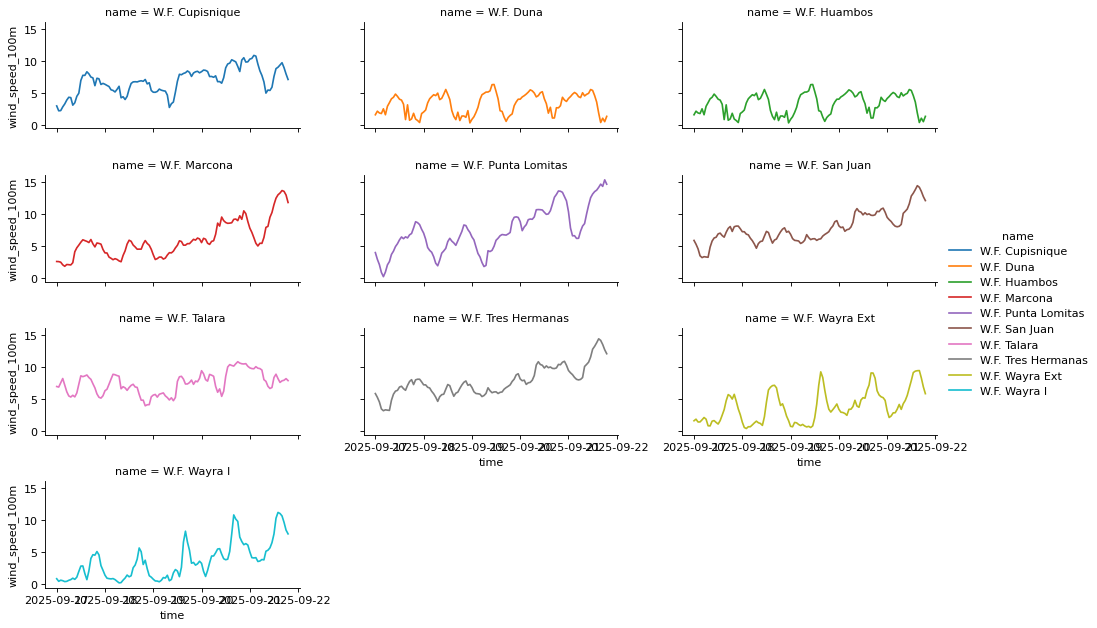

In [40]:
g = sns.relplot(
    data=df_all,
    x="time", y="wind_speed_100m",
    col="name", col_wrap=3, kind="line",
    hue="name", height=2, aspect=2,
)
g.fig.set_dpi(80)

In [60]:
#-- Read datasets --#
import pandas as pd
import numpy as np
import os
df_obs = pd.read_parquet('../dataset/ecmwf_windSpeed.parquet')
df_fc  = pd.read_parquet('../dataset/windSpeedFcs.parquet')

In [83]:
svars = ['name', 'date','wind_speed_100m']
fvars = svars + ['initDate', 'wwind100','nleadDays','model']
df_obs_fc = pd.merge(df_obs[svars], df_fc, how='outer', on=['name','date']).dropna(subset='initDate')[fvars]
df_obs_fc.rename({'wind_speed_100m':'obsWind', 'wwind100':'fcWind', 'nleadDays':'lead_days'}, axis=1, inplace=True)
df_obs_fc

,name,date,obsWind,initDate,fcWind,lead_days,model
187,W.F. Cupisnique,2025-09-15 19:00:00,6.71,2025-09-15 19:00:00,6.823297,0,GFS
188,W.F. Cupisnique,2025-09-15 19:00:00,6.71,2025-09-15 19:00:00,9.002163,0,IFS
189,W.F. Cupisnique,2025-09-15 20:00:00,6.89,2025-09-15 19:00:00,5.446298,0,GFS
190,W.F. Cupisnique,2025-09-15 21:00:00,6.43,2025-09-15 19:00:00,5.642835,0,GFS
191,W.F. Cupisnique,2025-09-15 22:00:00,5.76,2025-09-15 19:00:00,5.177117,0,GFS
...,...,...,...,...,...,...,...
73135,W.F. Wayra I,2025-10-08 04:00:00,NaN,2025-09-22 13:00:00,2.237982,15,GFS
73136,W.F. Wayra I,2025-10-08 07:00:00,NaN,2025-09-22 07:00:00,2.017698,16,GFS
73137,W.F. Wayra I,2025-10-08 07:00:00,NaN,2025-09-22 13:00:00,2.081294,15,GFS
73138,W.F. Wayra I,2025-10-08 10:00:00,NaN,2025-09-22 13:00:00,2.225133,15,GFS


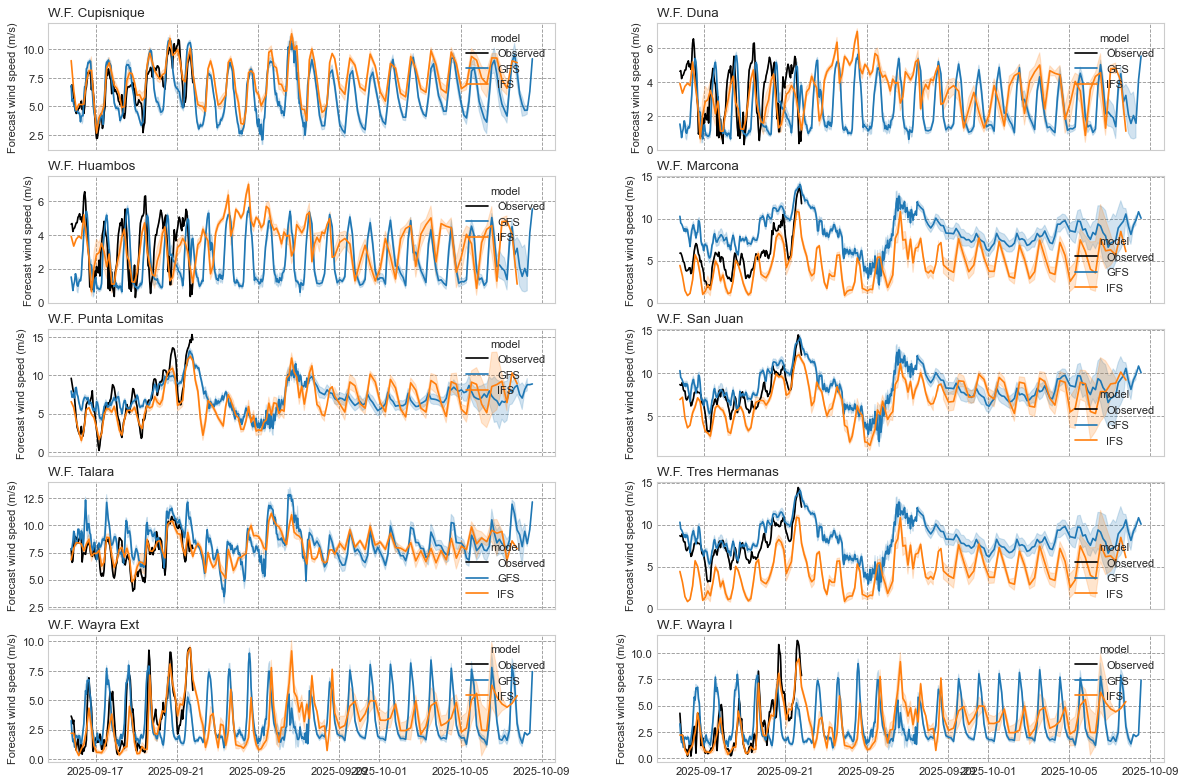

In [80]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(figsize=(18,12), dpi=80, ncols=2, nrows=5, sharex=True)
snames = df_obs_fc['name'].unique()
for n, ax in enumerate(axs.flatten()):
    if n >= len(snames):
        ax.axis('off')
        continue
    name = snames[n]
    sub = df_obs_fc[df_obs_fc['name'] == name]
    sns.lineplot(data=sub, x='date', y='wind_speed_100m', ax=ax, label='Observed', color='black')
    sns.lineplot(data=sub, x='date', y='wwind100', ax=ax, hue='model')
    ax.set_title(name, loc='left', size=12)
    ax.set_xlabel('Forecast/Observed\n Wind Speed (m/s)')
    ax.set_ylabel('Forecast wind speed (m/s)')
    ax.grid(ls='--', c='gray', alpha=.8)
    ax.set_xlabel('')

In [85]:
# --- Imports ---
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# =======================
# Parámetros
# =======================
max_lead = 6              # horizonte (0..max_lead)
site_filter = None         # p.ej. "W.F. Cupisnique" o None para todos
models_expected = ["GFS", "IFS"]  # ajusta si tienes más/otros modelos

# =======================
# 1) Preparación del DF (usa tu df_obs_fc)
# =======================
df = df_obs_fc.copy()

# Filtro por sitio (opcional)
if site_filter:
    df = df[df["name"] == site_filter].copy()

# Tipos
df["date_dt"] = pd.to_datetime(df["date"], errors="coerce")
df["init_dt"] = pd.to_datetime(df["initDate"], errors="coerce")

# Normaliza a día (estadístico diario)
df["date_d"] = df["date_dt"].dt.normalize()
df["init_d"] = df["init_dt"].dt.normalize()

# Asegura numéricos
df["obsWind"] = pd.to_numeric(df["obsWind"], errors="coerce")
df["fcWind"]  = pd.to_numeric(df["fcWind"], errors="coerce")

# =======================
# 2) MAPE por hora y promedio diario
#    MAPE = 100 * mean( |fc - obs| / |obs| ), ignorando obs <= 0 o NaN
# =======================
# Filtra horas válidas
mask_valid = df["obsWind"].notna() & df["fcWind"].notna() & (df["obsWind"] > 0)
df_valid = df.loc[mask_valid].copy()

# Error porcentual absoluto por hora
df_valid["ape"] = (df_valid["fcWind"] - df_valid["obsWind"]).abs() / df_valid["obsWind"] * 100.0

# Promedio diario por (modelo, fecha válida, fecha de init)
daily = (
    df_valid.groupby(["model", "date_d", "init_d"], as_index=False)
            .agg(mape=("ape","mean"), n=("ape","size"))
)

# =======================
# 3) Definir ventana cuadrada X=init, Y=forecast (últimos max_lead días)
# =======================
last_day = daily["date_d"].max()
if pd.isna(last_day):
    raise ValueError("No hay datos suficientes para calcular MAPE diario (revisa NaNs/ceros en obsWind).")

axis_days = pd.date_range(last_day - pd.Timedelta(days=max_lead), last_day, freq="D")
x_order = list(axis_days)   # init dates (X)
y_order = list(axis_days)   # forecast dates (Y)

x_labels = [d.strftime("%b%d") for d in x_order]
y_labels = [d.strftime("%b%d") for d in y_order]

# =======================
# 4) Construir matrices MAPE (y × x) por modelo con máscara triangular
#    - MAPE diario promedio
#    - COUNT de horas para el hover
#    - Solo llena si 0 <= (Y - X).days <= max_lead
# =======================
def matrices_mape(model_name: str):
    sub = daily[daily["model"].str.upper() == model_name.upper()].copy()
    # lookup por par (date_d, init_d)
    lut_mape = {(r.date_d, r.init_d): r["mape"] for _, r in sub.iterrows()}
    lut_n    = {(r.date_d, r.init_d): r["n"]    for _, r in sub.iterrows()}

    Z = np.full((len(y_order), len(x_order)), np.nan, dtype=float)  # MAPE
    N = np.zeros((len(y_order), len(x_order)), dtype=int)           # count de horas

    for i, y in enumerate(y_order):
        for j, x in enumerate(x_order):
            lead = (y - x).days
            if 0 <= lead <= max_lead:
                mape_val = lut_mape.get((y, x), np.nan)
                n_val    = lut_n.get((y, x), 0)
                Z[i, j] = mape_val
                N[i, j] = n_val
            # else: permanece NaN / 0 (fuera de la máscara)
    return Z, N

Z_by_model = {}
N_by_model = {}
for m in models_expected:
    Z_by_model[m], N_by_model[m] = matrices_mape(m)

# =======================
# 5) Figura: modelos como COLUMNAS (GFS | IFS), heatmap continuo de MAPE
#    - Eje Y invertido (recientes arriba)
#    - Hover con MAPE, lead y n
# =======================
fig = make_subplots(
    rows=1, cols=len(models_expected),
    subplot_titles=tuple(models_expected),
    shared_yaxes=True,
    horizontal_spacing=0.08 if len(models_expected) > 1 else 0.02
)

# Rango de color para MAPE (ajústalo a tus niveles); p.ej. 0–60%
zmin, zmax = 0, 60
colorscale = "RdYlGn_r"  # verde=bajo error, rojo=alto error

def add_panel(model_name: str, col: int):
    Z = Z_by_model[model_name]
    N = N_by_model[model_name]

    # Para hover: lead en días por celda
    lead_grid = np.zeros_like(Z, dtype=float)
    for i, y in enumerate(y_order):
        for j, x in enumerate(x_order):
            lead_grid[i, j] = (y - x).days

    fig.add_trace(
        go.Heatmap(
            z=Z,
            x=x_labels,  # init (release)
            y=y_labels,  # forecast date (valid)
            colorscale=colorscale,
            zmin=zmin, zmax=zmax,
            colorbar=dict(title="MAPE (%)") if col == len(models_expected) else None,
            xgap=2, ygap=2,
            hovertemplate=(
                "Init: %{x}<br>"
                "Forecast: %{y}<br>"
                "Lead: %{customdata[0]} d<br>"
                "MAPE: %{z:.1f}%<br>"
                "n (horas): %{customdata[1]}<extra></extra>"
            ),
            customdata=np.dstack([lead_grid, N]),
            name=f"{model_name} MAPE"
        ),
        row=1, col=col
    )

# Añade cada modelo en una columna
for ci, m in enumerate(models_expected, start=1):
    add_panel(m, col=ci)

# Ejes y layout
for ci in range(1, len(models_expected)+1):
    fig.update_xaxes(title_text="Init date (release) · %b%d", row=1, col=ci)

fig.update_yaxes(title_text="Forecast date · %b%d", row=1, col=1)
fig.update_yaxes(autorange="reversed", row=1, col=1)  # invierte Y para ambos subplots

title_suffix = f"{x_labels[0]} → {x_labels[-1]}"
if site_filter:
    title_prefix = f"{site_filter} · "
else:
    title_prefix = ""

fig.update_layout(
    title=f"{title_prefix}MAPE diario por Init (X) vs Forecast (Y) · Ventana: {title_suffix}",
    margin=dict(t=80, r=20, b=60, l=90),
    plot_bgcolor="white",
    paper_bgcolor="white"
)

fig.show()

In [88]:
# --- Imports ---
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# =======================
# Parámetros
# =======================
max_lead = 6                 # horizonte (0..max_lead)
site_filter = None            # p.ej. "W.F. Cupisnique" o None para todos
models_expected = ["GFS", "IFS"]  # ajusta si tienes más/otros modelos

# Clasificación MAPE (Lewis, 1982)
bins   = [-np.inf, 10, 20, 50, np.inf]
labels = ["Excellent", "Good", "Reasonable", "Poor"]
class_colors = {
    "Excellent":  "#2ECC71",  # green
    "Good":       "#F1C40F",  # yellow
    "Reasonable": "#E67E22",  # orange
    "Poor":       "#E74C3C",  # red
}

# =======================
# 1) Preparación del DF (usa tu df_obs_fc)
# =======================
df = df_obs_fc.copy()

# Filtra sitio (opcional)
if site_filter:
    df = df[df["name"] == site_filter].copy()

# Tipos
df["date_dt"] = pd.to_datetime(df["date"], errors="coerce")
df["init_dt"] = pd.to_datetime(df["initDate"], errors="coerce")

# Normaliza a día (estadística diaria)
df["date_d"] = df["date_dt"].dt.normalize()
df["init_d"] = df["init_dt"].dt.normalize()

# Asegura numéricos
df["obsWind"] = pd.to_numeric(df["obsWind"], errors="coerce")
df["fcWind"]  = pd.to_numeric(df["fcWind"],  errors="coerce")

# =======================
# 2) MAPE horario y promedio diario
#    MAPE = 100 * mean(|fc - obs| / |obs|) sobre horas válidas
# =======================
mask_valid = df["obsWind"].notna() & df["fcWind"].notna() & (df["obsWind"] > 0)
dfv = df.loc[mask_valid].copy()
dfv["ape"] = (dfv["fcWind"] - dfv["obsWind"]).abs() / dfv["obsWind"] * 100.0

daily = (
    dfv.groupby(["model", "date_d", "init_d"], as_index=False)
       .agg(mape=("ape", "mean"), n=("ape", "size"))
)

# =======================
# 3) Ventana cuadrada (últimos max_lead días) y etiquetas
# =======================
last_day = daily["date_d"].max()
if pd.isna(last_day):
    raise ValueError("No hay datos suficientes para calcular MAPE diario.")

axis_days = pd.date_range(last_day - pd.Timedelta(days=max_lead), last_day, freq="D")
x_order = list(axis_days)  # init
y_order = list(axis_days)  # forecast

x_labels = [d.strftime("%b%d") for d in x_order]
y_labels = [d.strftime("%b%d") for d in y_order]

# =======================
# 4) Matrices por CLASE y MODELO (triángulo: 0 <= lead <= max_lead)
# =======================
def class_mats_for_model(model_name: str):
    sub = daily[daily["model"].str.upper() == model_name.upper()].copy()
    lut = {(r.date_d, r.init_d): r["mape"] for _, r in sub.iterrows()}

    # Matriz base de MAPE y de clase string (para hover)
    Zmape = np.full((len(y_order), len(x_order)), np.nan, dtype=float)
    Cstr  = np.empty((len(y_order), len(x_order)), dtype=object); Cstr[:] = None

    for i, y in enumerate(y_order):
        for j, x in enumerate(x_order):
            lead = (y - x).days
            if 0 <= lead <= max_lead:
                m = lut.get((y, x), np.nan)
                Zmape[i, j] = m
                if np.isnan(m):
                    Cstr[i, j] = None
                else:
                    # clasifica por bins
                    cat = pd.cut([m], bins=bins, labels=labels, right=False)[0]
                    Cstr[i, j] = str(cat)
            # fuera de triángulo quedan NaN/None

    # Una matriz por clase con 1 donde coincide la clase (para colorear sólido)
    mats = {cls: np.where(np.array(Cstr, dtype=object) == cls, 1.0, np.nan).astype(float)
            for cls in labels}

    # Para hover: lead y n (conteo de horas) por celda
    lead_grid = np.zeros_like(Zmape)
    n_grid = np.zeros_like(Zmape)
    lut_n = {(r.date_d, r.init_d): r["n"] for _, r in sub.iterrows()}
    for i, y in enumerate(y_order):
        for j, x in enumerate(x_order):
            lead_grid[i, j] = (y - x).days
            n_grid[i, j]    = lut_n.get((y, x), 0)

    return mats, Zmape, Cstr, lead_grid, n_grid

model_panels = {}
for m in models_expected:
    model_panels[m] = class_mats_for_model(m)

# =======================
# 5) Figura: modelos como COLUMNAS; leyenda con puntos circulares
# =======================
fig = make_subplots(
    rows=1, cols=len(models_expected),
    subplot_titles=tuple(models_expected),
    shared_yaxes=True,
    horizontal_spacing=0.08 if len(models_expected) > 1 else 0.02
)

def add_panel(model_name: str, col: int):
    mats, Zmape, Cstr, lead_grid, n_grid = model_panels[model_name]
    # Traza por CLASE (color sólido), sin colorbar
    for cls in labels:
        fig.add_trace(
            go.Heatmap(
                z=mats[cls],
                x=x_labels,
                y=y_labels,
                colorscale=[[0, class_colors[cls]], [1, class_colors[cls]]],
                zmin=0, zmax=1,
                showscale=False,
                xgap=2, ygap=2,
                # hover usa el Zmape real y la clase:
                text=np.vectorize(lambda v: "" if v is None else v)(Cstr),
                customdata=np.dstack([lead_grid, Zmape, n_grid]),
                hovertemplate=(
                    "Init: %{x}<br>"
                    "Forecast: %{y}<br>"
                    "Lead: %{customdata[0]} d<br>"
                    "Clase: %{text}<br>"
                    "MAPE: %{customdata[1]:.1f}%<br>"
                    "n (horas): %{customdata[2]:.0f}<extra></extra>"
                ),
                name=cls,
                legendgroup=cls,
                showlegend=False  # ocultamos los rectángulos en la leyenda
            ),
            row=1, col=col
        )

# Añade paneles por modelo (columnas)
for ci, m in enumerate(models_expected, start=1):
    add_panel(m, col=ci)

# Leyenda con marcadores circulares (una por clase, toggle en ambos paneles)
for cls in labels:
    fig.add_trace(
        go.Scatter(
            x=[None], y=[None],
            mode="markers",
            marker=dict(size=12, color=class_colors[cls], symbol="circle"),
            name=cls,
            legendgroup=cls,
        )
    )

# Ejes y layout
for ci in range(1, len(models_expected)+1):
    fig.update_xaxes(title_text="Init date (release) · %b%d", row=1, col=ci)

fig.update_yaxes(title_text="Forecast date · %b%d", row=1, col=1)
fig.update_yaxes(autorange="reversed", row=1, col=1)  # recientes arriba

title_suffix = f"{x_labels[0]} → {x_labels[-1]}"
site_title = f"{site_filter} · " if site_filter else ""
fig.update_layout(
    title=f"{site_title}MAPE · Ventana: {title_suffix}",
    margin=dict(t=80, r=20, b=60, l=90),
    plot_bgcolor="white",
    paper_bgcolor="white",
    legend=dict(
        orientation="h",
        yanchor="bottom", y=1.10,
        xanchor="center", x=0.5
    ),
    legend_groupclick="togglegroup"  # click en clase alterna ambos paneles
)

fig.show()

In [ ]:
g = sns.relplot(
    data=df_obs_fc,
    x="time", y="wind_speed_100m",
    col="name", col_wrap=3, kind="line",
    hue="name", height=2, aspect=2,
)
g.fig.set_dpi(80)

In [64]:
df_obs

,name,lat,lon,date,wind_speed_10m,wind_direction_10m,wind_gusts_10m,wind_speed_100m,wind_direction_100m
0,W.F. Cupisnique,-7.55,-79.48,2025-09-08 00:00:00,6.45,157.0,9.5,9.13,158.0
1,W.F. Cupisnique,-7.55,-79.48,2025-09-08 01:00:00,5.85,157.0,9.2,8.79,158.0
2,W.F. Cupisnique,-7.55,-79.48,2025-09-08 02:00:00,5.98,156.0,8.7,8.84,156.0
3,W.F. Cupisnique,-7.55,-79.48,2025-09-08 03:00:00,6.04,153.0,8.7,8.79,155.0
4,W.F. Cupisnique,-7.55,-79.48,2025-09-08 04:00:00,6.42,154.0,9.1,8.90,155.0
...,...,...,...,...,...,...,...,...,...
3835,W.F. Wayra I,-15.04,-75.05,2025-09-23 19:00:00,NaN,NaN,NaN,NaN,NaN
3836,W.F. Wayra I,-15.04,-75.05,2025-09-23 20:00:00,NaN,NaN,NaN,NaN,NaN
3837,W.F. Wayra I,-15.04,-75.05,2025-09-23 21:00:00,NaN,NaN,NaN,NaN,NaN
3838,W.F. Wayra I,-15.04,-75.05,2025-09-23 22:00:00,NaN,NaN,NaN,NaN,NaN


In [65]:
df_fc

,initDate,date,name,wwind10,t2m,model,wwind100,nleadHour,nleadDays
0,2025-09-15 19:00:00,2025-09-15 19:00:00,W.F. Cupisnique,5.016495,16.650018,GFS,6.823297,0,0
1,2025-09-15 19:00:00,2025-09-15 20:00:00,W.F. Cupisnique,4.004123,16.483942,GFS,5.446298,1,0
2,2025-09-15 19:00:00,2025-09-15 21:00:00,W.F. Cupisnique,4.148618,16.329095,GFS,5.642835,2,0
3,2025-09-15 19:00:00,2025-09-15 22:00:00,W.F. Cupisnique,3.806221,16.166254,GFS,5.177117,3,0
4,2025-09-15 19:00:00,2025-09-15 23:00:00,W.F. Cupisnique,3.686104,16.013513,GFS,5.013737,4,0
...,...,...,...,...,...,...,...,...,...
71265,2025-09-22 19:00:00,2025-10-06 19:00:00,W.F. Wayra I,5.974217,13.404291,IFS,7.736442,336,14
71266,2025-09-22 19:00:00,2025-10-07 01:00:00,W.F. Wayra I,3.905390,11.092188,IFS,5.289060,342,14
71267,2025-09-22 19:00:00,2025-10-07 07:00:00,W.F. Wayra I,3.543519,11.261041,IFS,4.441349,348,14
71268,2025-09-22 19:00:00,2025-10-07 13:00:00,W.F. Wayra I,4.414821,23.851282,IFS,4.730645,354,14


In [6]:
df_obs.groupby('name').resample(on='date', rule='1D').agg({'NombreEmpresa':'median', 'windSpeed':'mean'}).reset_index()

KeyError: "Column(s) ['windSpeed'] do not exist"

In [14]:
# --- Imports ---
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# =========================================================
# 1) (Demo) Dataset con tu esquema. Reemplázalo por tu df real.
# =========================================================
np.random.seed(7)
today = pd.Timestamp.today().normalize()
start = today - pd.Timedelta(days=28)
max_lead = 14

valid_dates = pd.date_range(start, today, freq="D")
init_dates  = pd.date_range(start - pd.Timedelta(days=max_lead), today, freq="D")

def fmt(dt):  # %Y%m%d:%H:00
    return dt.strftime("%Y%m%d:00:00")

rows = []
for model in ["gfs", "ifs"]:
    for init in init_dates:
        for L in range(0, max_lead + 1):
            d = init + pd.Timedelta(days=L)
            if d < valid_dates.min() or d > valid_dates.max():
                continue
            obs = np.clip(np.random.normal(8, 2.0), 0, None)
            spread = (1.2 if model == "gfs" else 0.9) * (1 + 0.12 * L)
            fc = obs + np.random.normal(0, spread)
            rows.append([fmt(init), fmt(d), float(L), obs, fc, model])

df = pd.DataFrame(rows, columns=[
    "initDate", "date", "wndObs", "wndFcs", "leadDay", "model"
])

# =========================================================
# 2) Parseo + métrica + agregación diaria
# =========================================================
# Parseo seguro de fechas
df["initDate_dt"] = pd.to_datetime(df["initDate"], format="%Y%m%d:%H:00", errors="coerce")
df["date_dt"]     = pd.to_datetime(df["date"],     format="%Y%m%d:%H:00", errors="coerce")

# Normaliza a día (evita problemas de rename dentro de groupby)
df["init_d"] = df["initDate_dt"].dt.normalize()
df["date_d"] = df["date_dt"].dt.normalize()

# Métrica
df["abs_error"] = (df["wndFcs"] - df["wndObs"]).abs()

# Agregación diaria por (modelo, fecha válida, fecha de init)
daily = (
    df.groupby(["model", "date_d", "init_d"], as_index=False)["abs_error"]
      .mean()
      .rename(columns={"abs_error": "mean_abs_error"})
)

# =========================================================
# 3) Clasificación por clases
# =========================================================
bins   = [-np.inf, 1.0, 2.0, 3.0, np.inf]
labels = ["Low", "Medium", "High", "Critical"]
daily["class"] = pd.cut(daily["mean_abs_error"], bins=bins, labels=labels, right=False)

# =========================================================
# 4) Ejes: x = init (%b%d), y = forecast date (%b%d)
# =========================================================
x_order = sorted(daily["init_d"].unique())
y_order = sorted(daily["date_d"].unique())

x_labels = [x.strftime("%b%d") for x in x_order]
y_labels = [y.strftime("%b%d") for y in y_order]

# Mapea a etiquetas categóricas
map_x = dict(zip(x_order, x_labels))
map_y = dict(zip(y_order, y_labels))
daily["x_lab"] = daily["init_d"].map(map_x)
daily["y_lab"] = daily["date_d"].map(map_y)

# =========================================================
# 5) Matrices por clase y por modelo (y × x); NaN donde no hay intersección
# =========================================================
code_colors = {
    "Low":      "#4CAF50",
    "Medium":   "#F4C542",
    "High":     "#FF8C42",
    "Critical": "#E74C3C",
}

def matrices_by_class(model_name: str):
    sub = daily[daily["model"] == model_name].copy()
    # grilla completa (y, x)
    idx = pd.MultiIndex.fromProduct = pd.MultiIndex.from_product  # alias para evitar typos
    idx = pd.MultiIndex.from_product([y_labels, x_labels], names=["y_lab", "x_lab"])
    sub = sub.set_index(["y_lab", "x_lab"]).reindex(idx).reset_index()

    mats = {}
    for cls in labels:
        mask = (sub["class"] == cls).astype(float)
        mask[mask == 0.0] = np.nan
        mats[cls] = mask.values.reshape(len(y_labels), len(x_labels))
    return mats

Z_gfs = matrices_by_class("gfs")
Z_ifs = matrices_by_class("ifs")

# =========================================================
# 6) Figura: 2 columnas (GFS | IFS) y leyenda con puntos
# =========================================================
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("GFS", "IFS"),
    shared_yaxes=True,
    horizontal_spacing=0.08
)

def add_panel(Z_dict, col: int):
    for cls in labels:
        fig.add_trace(
            go.Heatmap(
                z=Z_dict[cls],
                x=x_labels,   # init (release)
                y=y_labels,   # forecast date (valid)
                colorscale=[[0, code_colors[cls]], [1, code_colors[cls]]],
                zmin=0, zmax=1,
                showscale=False,
                xgap=2, ygap=2,
                hovertemplate=(
                    "Init: %{x}<br>"
                    "Forecast: %{y}<br>"
                    f"Class: {cls}<extra></extra>"
                ),
                name=cls,
                legendgroup=cls,
                showlegend=False
            ),
            row=1, col=col
        )

add_panel(Z_gfs, col=1)
add_panel(Z_ifs, col=2)

# Leyenda con puntitos redondos (dummy scatters)
for cls in labels:
    fig.add_trace(
        go.Scatter(
            x=[None], y=[None],
            mode="markers",
            marker=dict(size=12, color=code_colors[cls], symbol="circle"),
            name=cls,
            legendgroup=cls,
        )
    )

# Layout
fig.update_xaxes(title_text="Init date (release) · %b%d", row=1, col=1)
fig.update_xaxes(title_text="Init date (release) · %b%d", row=1, col=2)
fig.update_yaxes(title_text="Forecast date · %b%d", row=1, col=1)

fig.update_layout(
    title="Daily Class by Init (x) vs Forecast Date (y) · Models as Columns",
    margin=dict(t=70, r=20, b=60, l=80),
    plot_bgcolor="white",
    paper_bgcolor="white",
    legend=dict(
        orientation="h",
        yanchor="bottom", y=1.12,
        xanchor="center", x=0.5
    ),
    legend_groupclick="togglegroup"
)

fig.show()


In [11]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# ---------------------------
# 1) Generar dataset sintético mejorado
# ---------------------------
np.random.seed(42)
today = pd.Timestamp.today().normalize()
start = today - pd.Timedelta(days=90)

dates = pd.date_range(start, today, freq="D")
models = ["GFS", "IFS"]

rows = []
for m in models:
    for d in dates:
        for L in range(0, 15):
            init = d - pd.Timedelta(days=L)
            base_wind = 8 + 3 * np.sin(2 * np.pi * (d.dayofyear / 365))
            obs = np.clip(np.random.normal(base_wind, 1.5), 2, 15)
            
            error_std = (1.5 if m=="GFS" else 1.0) * (1 + 0.12*L + 0.02*(L**2))
            fc = obs + np.random.normal(0, error_std)
            fc = np.clip(fc, 0, 20)
            
            rows.append([d, init, L, obs, fc, m])

df = pd.DataFrame(rows, columns=["date","initDate","lead_days","obsWind","fcWind","model"])

# ---------------------------
# 2) Clasificación mejorada
# ---------------------------
df["abs_error"] = (df["fcWind"] - df["obsWind"]).abs()
df["rel_error"] = (df["abs_error"] / df["obsWind"].clip(lower=1)) * 100

# Clasificación basada en percentiles
error_percentiles = df["abs_error"].quantile([0.25, 0.5, 0.75, 0.9]).values
bins = [-np.inf, error_percentiles[0], error_percentiles[1], error_percentiles[2], error_percentiles[3], np.inf]
labels = ["Muy Bajo","Bajo","Medio","Alto","Crítico"]
df["class"] = pd.cut(df["abs_error"], bins=bins, labels=labels, right=False)

# ---------------------------
# 3) Preparación de dimensiones temporales
# ---------------------------
df["week_of_month"] = df["date"].apply(lambda d: (d.day-1)//7 + 1)
df["month"] = df["date"].dt.month_name()
df["month_week"] = df["month"] + " - Semana " + df["week_of_month"].astype(str)

# ---------------------------
# 4) Agregación CORREGIDA - evitando duplicados
# ---------------------------
# Primero: agregación diaria básica
daily = (
    df.groupby(["model","date","lead_days"], as_index=False)
      .agg({
          "abs_error": "mean",
          "rel_error": "mean",
          "obsWind": "mean",
          "fcWind": "mean",
          "week_of_month": "first",
          "month": "first",
          "month_week": "first"
      })
      .rename(columns={"abs_error":"mean_abs_error", "rel_error":"mean_rel_error"})
)

# Clasificación basada en percentiles de los datos agregados
agg_percentiles = daily["mean_abs_error"].quantile([0.25, 0.5, 0.75, 0.9]).values
daily_bins = [-np.inf, agg_percentiles[0], agg_percentiles[1], agg_percentiles[2], agg_percentiles[3], np.inf]
daily["class"] = pd.cut(daily["mean_abs_error"], bins=daily_bins, labels=labels, right=False)

# ---------------------------
# 5) Preparación de matrices CORREGIDA
# ---------------------------
lead_days = list(range(0, 15))
class_to_code = {label: i for i, label in enumerate(labels)}
code_to_class = {v: k for k, v in class_to_code.items()}

def create_matrix_data(model_name):
    sub = daily[daily["model"] == model_name].copy()
    
    # Agregar por month_week y lead_days para evitar duplicados
    weekly_agg = (
        sub.groupby(["month_week", "lead_days"], as_index=False)
          .agg({
              "mean_abs_error": "mean",
              "class": lambda x: x.mode()[0] if not x.mode().empty else "Muy Bajo"
          })
    )
    
    # Obtener month_weeks únicos y ordenados
    month_weeks = sorted(weekly_agg["month_week"].unique())
    
    # Crear matriz completa
    Z = np.full((len(month_weeks), len(lead_days)), -1, dtype=float)
    values_matrix = np.full((len(month_weeks), len(lead_days)), 0, dtype=float)
    
    # Llenar matrices
    for i, mw in enumerate(month_weeks):
        for j, lead in enumerate(lead_days):
            mask = (weekly_agg["month_week"] == mw) & (weekly_agg["lead_days"] == lead)
            if mask.any():
                row = weekly_agg[mask].iloc[0]
                Z[i, j] = class_to_code.get(row["class"], 0)
                values_matrix[i, j] = row["mean_abs_error"]
    
    return Z, values_matrix, month_weeks

Z_gfs, values_gfs, y_labels_gfs = create_matrix_data("GFS")
Z_ifs, values_ifs, y_labels_ifs = create_matrix_data("IFS")

# ---------------------------
# 6) Esquema de colores mejorado
# ---------------------------
colorscale = [
    [0.0, "#2E86AB"],    # Muy Bajo - Azul claro
    [0.2, "#2E86AB"],    
    [0.2, "#A3B18A"],    # Bajo - Verde suave
    [0.4, "#A3B18A"],
    [0.4, "#F4C542"],    # Medio - Amarillo
    [0.6, "#F4C542"],
    [0.6, "#FF8C42"],    # Alto - Naranja
    [0.8, "#FF8C42"],
    [0.8, "#E74C3C"],    # Crítico - Rojo
    [1.0, "#E74C3C"]
]

# ---------------------------
# 7) Figura mejorada
# ---------------------------
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=(
        "<b>GFS - Global Forecast System</b>", 
        "<b>IFS - Integrated Forecast System</b>"
    ),
    shared_xaxes=True,
    vertical_spacing=0.08,
    row_heights=[0.48, 0.52]
)

def add_heatmap(Z, values, y_labels, row, model_name):
    hover_text = []
    for i, week_label in enumerate(y_labels):
        row_text = []
        for j, lead in enumerate(lead_days):
            error_val = values[i, j]
            class_code = Z[i, j]
            class_name = code_to_class.get(int(class_code), "Sin datos") if class_code >= 0 else "Sin datos"
            
            if class_code >= 0:
                row_text.append(
                    f"<b>{model_name}</b><br>"
                    f"Período: {week_label}<br>"
                    f"Lead Time: {lead} días<br>"
                    f"Clase: {class_name}<br>"
                    f"Error Absoluto: {error_val:.2f} m/s"
                )
            else:
                row_text.append(
                    f"<b>{model_name}</b><br>"
                    f"Período: {week_label}<br>"
                    f"Lead Time: {lead} días<br>"
                    f"Clase: Sin datos<br>"
                    f"Error Absoluto: N/A"
                )
        hover_text.append(row_text)
    
    heatmap = go.Heatmap(
        z=Z,
        x=lead_days,
        y=y_labels,
        text=hover_text,
        hoverinfo="text",
        colorscale=colorscale,
        zmin=0,
        zmax=4,
        showscale=False,
        hovertemplate="%{text}<extra></extra>",
        name=model_name
    )
    
    fig.add_trace(heatmap, row=row, col=1)

add_heatmap(Z_gfs, values_gfs, y_labels_gfs, 1, "GFS")
add_heatmap(Z_ifs, values_ifs, y_labels_ifs, 2, "IFS")

# ---------------------------
# 8) Leyenda interactiva
# ---------------------------
legend_colors = ["#2E86AB", "#A3B18A", "#F4C542", "#FF8C42", "#E74C3C"]
legend_labels = ["Muy Bajo", "Bajo", "Medio", "Alto", "Crítico"]

for color, label in zip(legend_colors, legend_labels):
    fig.add_trace(
        go.Scatter(
            x=[None], y=[None],
            mode="markers",
            marker=dict(size=15, color=color),
            name=label,
            legendgroup="legend",
            showlegend=True
        )
    )

# ---------------------------
# 9) Personalización final
# ---------------------------
fig.update_xaxes(
    title_text="<b>Lead Time (días)</b>", 
    row=2, col=1,
    tickvals=lead_days[::2],
    gridcolor="lightgray",
    gridwidth=1
)

fig.update_yaxes(
    title_text="<b>Período (Mes - Semana)</b>", 
    row=1, col=1,
    gridcolor="lightgray",
    gridwidth=1
)

fig.update_yaxes(
    title_text="<b>Período (Mes - Semana)</b>", 
    row=2, col=1,
    gridcolor="lightgray",
    gridwidth=1
)

fig.update_layout(
    title=dict(
        text="<b>Análisis de Calidad de Pronóstico por Lead Time y Período</b><br>"
             "<sub>Clasificación basada en error absoluto medio del viento (m/s)</sub>",
        x=0.5,
        xanchor="center",
        font=dict(size=20, color="#2C3E50")
    ),
    margin=dict(t=120, r=30, b=80, l=100),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5,
        font=dict(size=12),
        bgcolor="rgba(255,255,255,0.8)"
    ),
    plot_bgcolor="white",
    paper_bgcolor="white",
    font=dict(family="Arial, sans-serif", color="#2C3E50"),
    height=800,
    width=1000
)

# Añadir anotaciones explicativas
fig.add_annotation(
    text="💡 <b>Interpretación:</b> Colores más cálidos indican mayor error de pronóstico",
    xref="paper", yref="paper",
    x=0.02, y=-0.12,
    showarrow=False,
    font=dict(size=11, color="#7F8C8D"),
    align="left"
)

fig.show()

# ---------------------------
# 10) Gráfico adicional de tendencia
# ---------------------------
error_by_lead = daily.groupby(["model", "lead_days"]).agg({
    "mean_abs_error": "mean",
    "mean_rel_error": "mean"
}).reset_index()

fig2 = go.Figure()

colors = {"GFS": "#1f77b4", "IFS": "#ff7f0e"}
for model in models:
    model_data = error_by_lead[error_by_lead["model"] == model]
    fig2.add_trace(go.Scatter(
        x=model_data["lead_days"],
        y=model_data["mean_abs_error"],
        name=model,
        mode="lines+markers",
        line=dict(width=3, color=colors[model]),
        marker=dict(size=8, color=colors[model])
    ))

fig2.update_layout(
    title="<b>Evolución del Error Absoluto Medio por Lead Time</b>",
    xaxis_title="Lead Time (días)",
    yaxis_title="Error Absoluto Medio (m/s)",
    template="plotly_white",
    height=400,
    width=1000,
    font=dict(family="Arial, sans-serif", color="#2C3E50")
)

fig2.show()